In [1]:
!git clone https://github.com/Kangningthu/DeepDenoisingGuide

Cloning into 'DeepDenoisingGuide'...
remote: Enumerating objects: 869, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 869 (delta 27), reused 123 (delta 22), pack-reused 739 (from 1)
Receiving objects: 100% (869/869), 337.62 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (1167/1167), done.


In [2]:
import argparse
import os
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import torch.nn.functional as F

import sys
file_root_path = '/content/DeepDenoisingGuide'
sys.path.append(file_root_path + "/electron-microscopy-denoising")

import data
import models
import utils

In [3]:
checkpoint_path = file_root_path + '/electron-microscopy-denoising/checkpoints/unet-128-small.pt'

In [4]:
USE_CUDA = False
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [5]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))

    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [6]:
net = load_model(checkpoint_path).to(device)
_ = net.eval()

<ipython-input-5-8e512eb5c387>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load( checkpoint_path, map_location=lambda s,


In [7]:
x = torch.from_numpy(np.load(file_root_path + '/electron-microscopy-denoising/images/real_data/00000.npy'))
noisy = x.to(device).unsqueeze(0)
noisy = noisy[:, :, 400:700, 400:700]
noisy = noisy.requires_grad_(True)
with torch.no_grad():
    denoised = net(noisy)

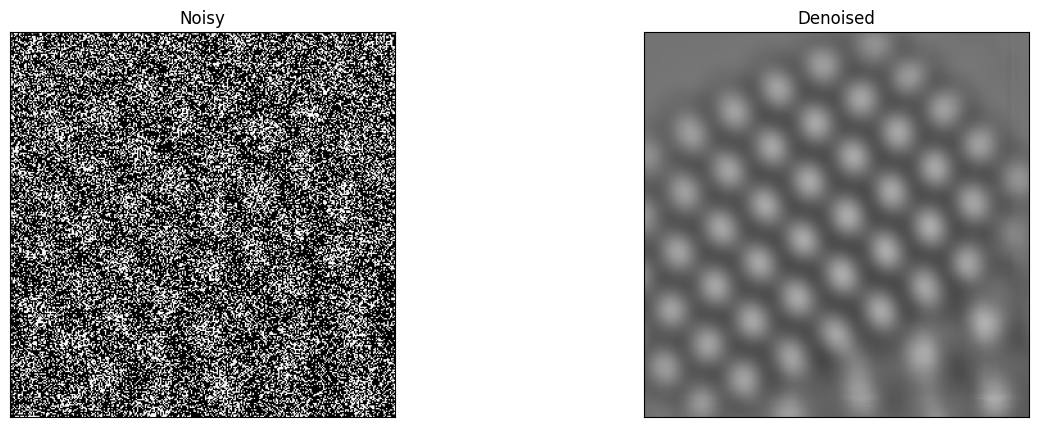

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True, sharey = True, figsize = (15, 5))

axes[0].imshow(noisy.data.cpu().numpy()[0, 0], cmap='gray', vmax=1.0, vmin = 0)
axes[0].set_title("Noisy")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(denoised.data.cpu().numpy()[0, 0], cmap='gray', vmax=1.0, vmin = 0)
axes[1].set_title("Denoised")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

In [38]:
pixels = [(55,55),(55,245),(245,245),(150,150)]

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True, sharey = True, figsize = (10, 5))

# plot noisy
axes[0].imshow(noisy[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

# denoise
noisy.requires_grad = True
denoised = net(noisy)

# plot denoised
axes[1].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

for j, (ix, iy) in enumerate(pixels):
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    pa2 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)
    axes[1].add_patch(pa2)

plt.show()


width = 50
photo_num = 0
for j, (ix, iy) in enumerate(pixels):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (22, 6))

    im = axes[0].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)


    filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy()

    photo_num += 1
    print(photo_num, denoised[0, 0, iy, ix].cpu().data.numpy(),
          np.sum(noisy.cpu().data.numpy()*filt),
          denoised[0, 0, iy, ix].cpu().data.numpy() - np.sum(noisy.cpu().data.numpy()*filt) )

    limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
    limit /= 2
    im = axes[1].imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
    axes[2].imshow(denoised[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
    axes[3].imshow(filt[iy-width:iy+width, ix-width:ix+width], 'coolwarm' if True else 'gray', vmin= -limit, vmax = limit)
    axes[4].imshow(noisy[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)

    pa2 = patches.Rectangle( ( width, width) ,
                    width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[2].add_patch(pa2)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.